# MA amplitude & GSEA p53

In [1]:
# Loading R packages.
suppressMessages(library(DESeq2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(ggrepel))
suppressMessages(library(viridis))
suppressMessages(library(EnhancedVolcano))
suppressMessages(library(fgsea))
suppressMessages(library(scales))
suppressMessages(library(grid))
suppressMessages(library(gridExtra))
suppressMessages(library(forcats))

In [2]:
# Define input/output paths and files for DESeq2.
baseDir <- "/scratch/Users/dara6367/RNA-seq_interspecies-nutlin/"
countsDir <- paste0(baseDir,"featureCounts/")
outDir <- paste0(baseDir,"DESeq2/")
tableDir <- paste0(baseDir,"misc/")
contrast <- c("treatment", "Nutlin", "DMSO")
alphaValue <- 0.05

species <- "Human"
libraryType <- "RNA"

conditionsTableFile <- paste0(tableDir,"conditionsTable.", libraryType, "-Nutlin-", species, ".csv")

#############################################
            # Complete annotation
#############################################

if(libraryType == "RNA"){
    featureCounts_all <- paste0("RNA-Nutlin-", species, ".GTFall.featureCounts.RData") }

if(libraryType == "PRO"){
    featureCounts_all <- paste0("PRO-Nutlin-", species, ".ncbiRefSeq.without5prime25.featureCounts.RData") }

# Read in count data and their conditions table.
load(paste0(countsDir, featureCounts_all))
conditionsTable <- read.csv(conditionsTableFile, header = TRUE)

# Assign the same ID to both the conditionTables row names and the counts column names.
colnames(counts$counts) <- conditionsTable$sample
rownames(conditionsTable) <- conditionsTable$sample

# Create DESeq2Dataset object and load RNA-seq counts.
dds_all <- DESeqDataSetFromMatrix(countData = counts$counts, 
                                 colData = conditionsTable,
                                 design = ~ treatment)

# Run DESeq2 using the counts.
dds_all <- DESeq(dds_all)

# 'Shrink' results using 'normal' mode.
resultsUnshrunken_all <- results(dds_all, 
                                contrast = contrast, 
                                alpha = alphaValue)
results_all <- lfcShrink(dds_all, 
                        contrast = contrast, 
                        res = resultsUnshrunken_all, 
                        type = "normal")

# Orders list of genes by their adjusted p-values.
results_all <- results_all[order(results_all$padj),]

#############################################
          # Standard-10 annotation
#############################################

if(libraryType == "RNA"){
    featureCounts_std <- paste0("RNA-Nutlin-", species, ".standard10.featureCounts.RData") }

if(libraryType == "PRO"){
    featureCounts_std <- paste0("PRO-Nutlin-", species, ".standard10.without5prime25.featureCounts.RData") }

# Read in count data and their conditions table.
load(paste0(countsDir, featureCounts_std))
conditionsTable <- read.csv(conditionsTableFile, header = TRUE)

# Assign the same ID to both the conditionTables row names and the counts column names.
colnames(counts$counts) <- conditionsTable$sample
rownames(conditionsTable) <- conditionsTable$sample

# Create DESeq2Dataset object and load counts.
dds_std <- DESeqDataSetFromMatrix(countData = counts$counts, 
                                 colData = conditionsTable,
                                 design = ~ treatment)

# Run DESeq2 using the counts.
dds_std <- DESeq(dds_std)

# 'Shrink' results using 'normal' mode.
resultsUnshrunken_std <- results(dds_std, 
                                contrast = contrast, 
                                alpha = alphaValue)
results_std <- lfcShrink(dds_std, 
                        contrast = contrast, 
                        res = resultsUnshrunken_std, 
                        type = "normal")

# Orders list of genes by their adjusted p-values.
results_std <- results_std[order(results_std$padj),]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



[1] "The responsive index using the complete annotation is: 0.2019"
[1] "The responsive index using the standard annotation is: 0.3124"


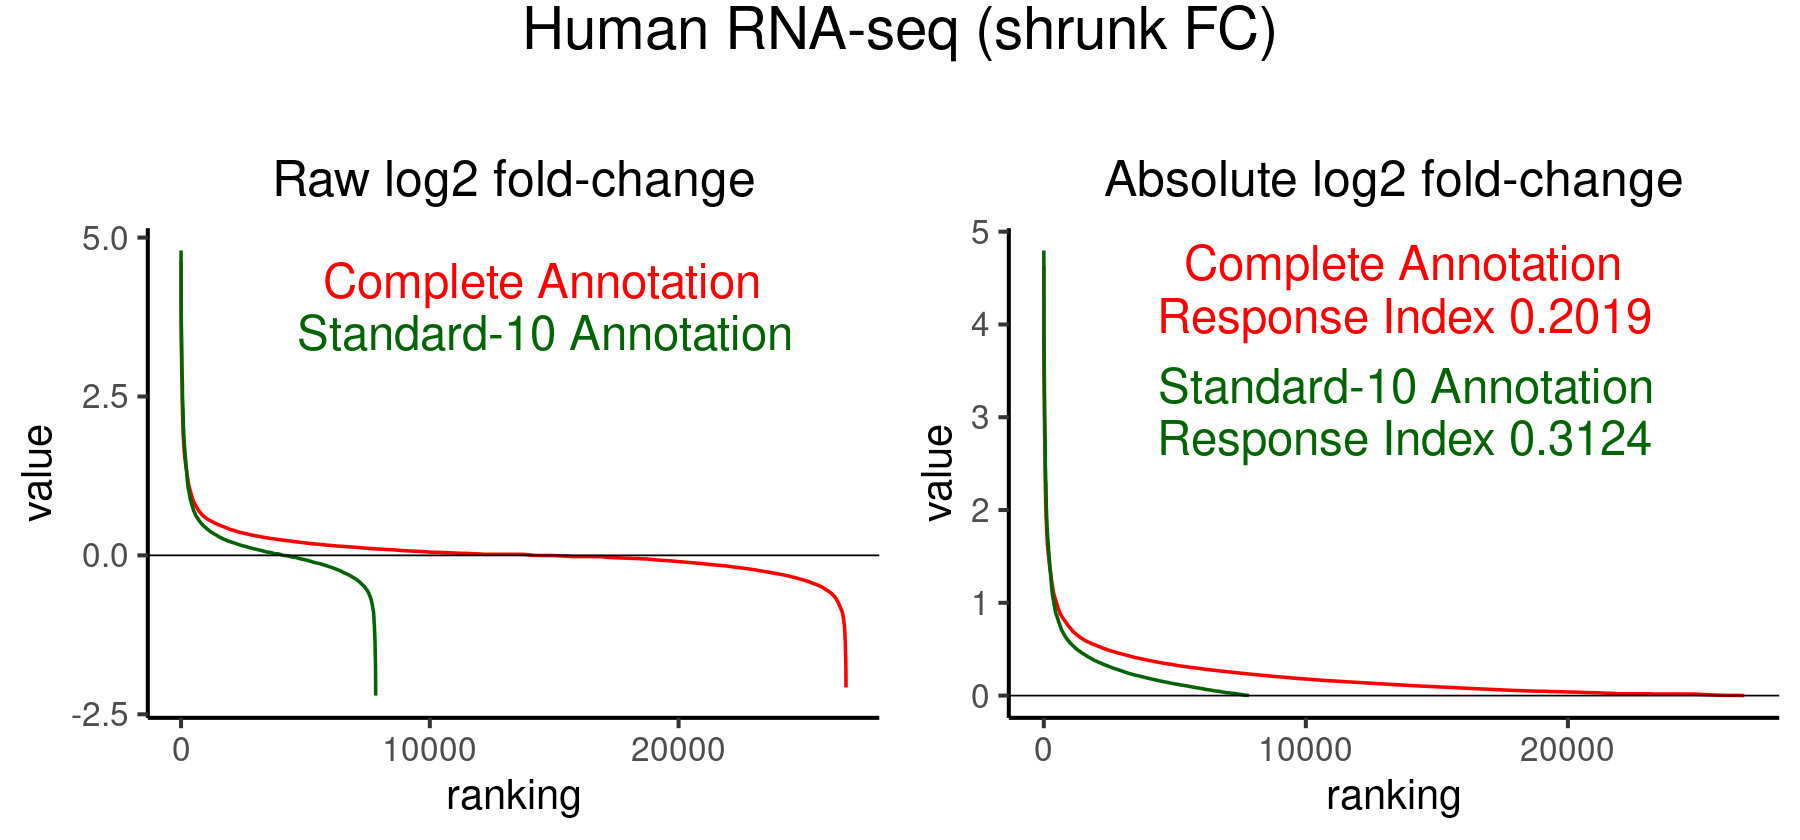

In [3]:
#############################################
         # Shrunk fold-change values
#############################################

# Complete annotation

# Filter out gene entries whose log2FoldChange has an NA value.
filtresults_all <- results_all[!is.na(results_all$log2FoldChange),]
# Orders the gene list by log2FoldChange in decreasing order.
filtresults_all <- filtresults_all[order(filtresults_all$log2FoldChange, decreasing = TRUE),]
rankedGenes_all <- filtresults_all$log2FoldChange
names(rankedGenes_all) <- rownames(filtresults_all)
rankedGenes_all_gsea <- rankedGenes_all
# Obtains the mean of the absolute fold-changes.
responsivenessIndex_all <- mean(abs(rankedGenes_all))
responsivenessIndex_all <- format(round(responsivenessIndex_all, 4), nsmall = 4)
print(paste0("The responsive index using the complete annotation is: ", responsivenessIndex_all))

# Standard-10 annotation

# Filter out gene entries whose log2FoldChange has an NA value.
filtresults_std <- results_std[!is.na(results_std$log2FoldChange),]
# Orders the gene list by log2FoldChange in decreasing order.
filtresults_std <- filtresults_std[order(filtresults_std$log2FoldChange, decreasing = TRUE),]
rankedGenes_std <- filtresults_std$log2FoldChange
names(rankedGenes_std) <- rownames(filtresults_std)
rankedGenes_std_gsea <- rankedGenes_std
# Obtains the mean of the absolute fold-changes.
responsivenessIndex_std <- mean(abs(rankedGenes_std))
responsivenessIndex_std <- format(round(responsivenessIndex_std, 4), nsmall = 4)
print(paste0("The responsive index using the standard annotation is: ", responsivenessIndex_std))

# Overlaid plots.
rankedGenes_all_temp <- rankedGenes_all
rankedGenes_all <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_all_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_all) <- colNames
rankedGenes_all$ranking <- seq(1:length(rankedGenes_all_temp))
rankedGenes_all$value <- rankedGenes_all_temp

rankedGenes_std_temp <- rankedGenes_std
rankedGenes_std <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_std_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_std) <- colNames
rankedGenes_std$ranking <- seq(1:length(rankedGenes_std_temp))
rankedGenes_std$value <- rankedGenes_std_temp

ranking_posneg <- ggplot() +
  geom_line(data = rankedGenes_all, aes(x = ranking, y = value), color = "red", size = 1) +
  geom_line(data = rankedGenes_std, aes(x = ranking, y = value), color = "darkgreen", size = 1) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black", size = 0.5) +
  labs(title = "Raw log2 fold-change") + 
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.4, vjust = -12, label = "Complete Annotation", size = 10, color = "red") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -10.5, label = "Standard-10 Annotation", size = 10, color = "darkgreen") +
  theme_classic(base_size = 25) +
  theme(plot.title = element_text(hjust = 0.5))

rankedGenes_all <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_all_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_all) <- colNames
rankedGenes_all$ranking <- seq(1:length(rankedGenes_all_temp))
rankedGenes_all$value <- sort(abs(rankedGenes_all_temp), decreasing = TRUE)

rankedGenes_std <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_std_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_std) <- colNames
rankedGenes_std$ranking <- seq(1:length(rankedGenes_std_temp))
rankedGenes_std$value <- sort(abs(rankedGenes_std_temp), decreasing = TRUE)

ranking_abs <- ggplot() +
  geom_line(data = rankedGenes_all, aes(x = ranking, y = value), color = "red", size = 1) +
  geom_line(data = rankedGenes_std, aes(x = ranking, y = value), color = "darkgreen", size = 1) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black", size = 0.5) +
  labs(title = "Absolute log2 fold-change") + 
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.4, vjust = -12.5, label = "Complete Annotation", size = 10, color = "red") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -11, label = paste0("Response Index ", responsivenessIndex_all), size = 10, color = "red") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -9, label = "Standard-10 Annotation", size = 10, color = "darkgreen") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -7.5, label = paste0("Response Index ", responsivenessIndex_std), size = 10, color = "darkgreen") +
  theme_classic(base_size = 25) +
  theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(ranking_posneg, ranking_abs, ncol = 2, top = textGrob(paste0(species, " ", libraryType,"-seq (shrunk FC)\n"), gp = gpar(fontsize = 35)))

[1] "The responsive index using the complete annotation is: 0.6550"
[1] "The responsive index using the standard annotation is: 0.5404"


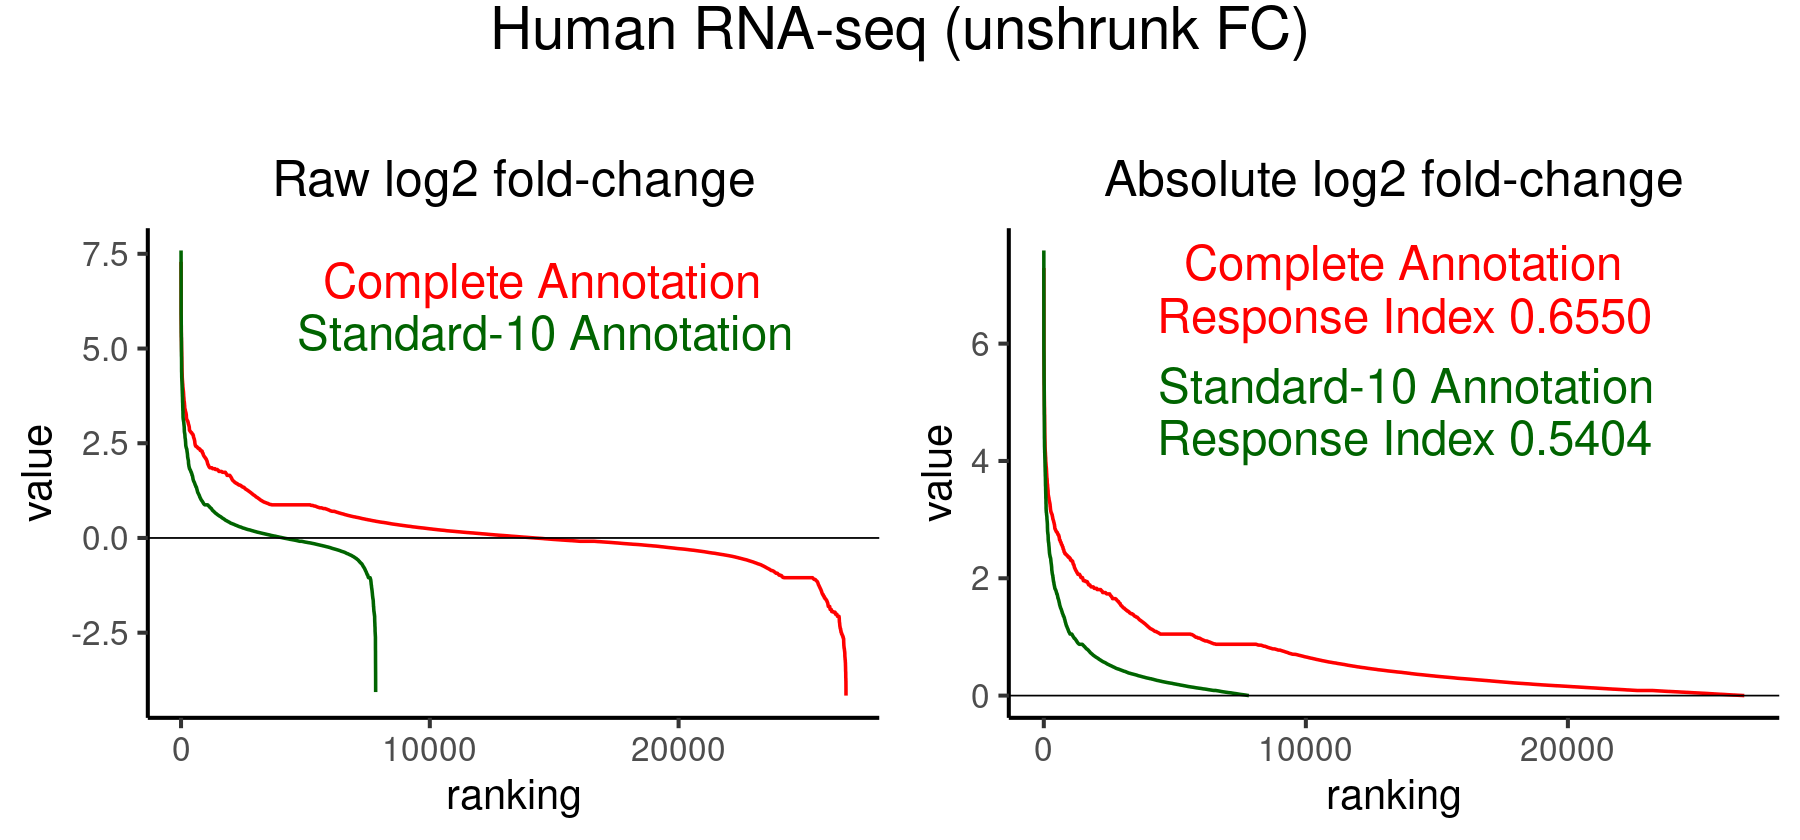

In [4]:
#############################################
        # Unshrunk fold-change values
#############################################

# Complete annotation

# Filter out gene entries whose log2FoldChange has an NA value.
filtresultsUnshrunken_all <- resultsUnshrunken_all[!is.na(resultsUnshrunken_all$log2FoldChange),]
# Orders the gene list by log2FoldChange in decreasing order.
filtresultsUnshrunken_all <- filtresultsUnshrunken_all[order(filtresultsUnshrunken_all$log2FoldChange, decreasing = TRUE),]
rankedGenes_all <- filtresultsUnshrunken_all$log2FoldChange
names(rankedGenes_all) <- rownames(filtresultsUnshrunken_all)
rankedGenes_all_gsea <- rankedGenes_all
# Obtains the mean of the absolute fold-changes.
responsivenessIndex_all <- mean(abs(rankedGenes_all))
responsivenessIndex_all <- format(round(responsivenessIndex_all, 4), nsmall = 4)
print(paste0("The responsive index using the complete annotation is: ", responsivenessIndex_all))

# Standard-10 annotation

# Filter out gene entries whose log2FoldChange has an NA value.
filtresultsUnshrunken_std <- resultsUnshrunken_std[!is.na(resultsUnshrunken_std$log2FoldChange),]
# Orders the gene list by log2FoldChange in decreasing order.
filtresultsUnshrunken_std <- filtresultsUnshrunken_std[order(filtresultsUnshrunken_std$log2FoldChange, decreasing = TRUE),]
rankedGenes_std <- filtresultsUnshrunken_std$log2FoldChange
names(rankedGenes_std) <- rownames(filtresultsUnshrunken_std)
rankedGenes_std_gsea <- rankedGenes_std
# Obtains the mean of the absolute fold-changes.
responsivenessIndex_std <- mean(abs(rankedGenes_std))
responsivenessIndex_std <- format(round(responsivenessIndex_std, 4), nsmall = 4)
print(paste0("The responsive index using the standard annotation is: ", responsivenessIndex_std))

# Overlaid plots.
rankedGenes_all_temp <- rankedGenes_all
rankedGenes_all <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_all_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_all) <- colNames
rankedGenes_all$ranking <- seq(1:length(rankedGenes_all_temp))
rankedGenes_all$value <- rankedGenes_all_temp

rankedGenes_std_temp <- rankedGenes_std
rankedGenes_std <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_std_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_std) <- colNames
rankedGenes_std$ranking <- seq(1:length(rankedGenes_std_temp))
rankedGenes_std$value <- rankedGenes_std_temp

ranking_posneg <- ggplot() +
  geom_line(data = rankedGenes_all, aes(x = ranking, y = value), color = "red", size = 1) +
  geom_line(data = rankedGenes_std, aes(x = ranking, y = value), color = "darkgreen", size = 1) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black", size = 0.5) +
  labs(title = "Raw log2 fold-change") + 
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.4, vjust = -12, label = "Complete Annotation", size = 10, color = "red") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -10.5, label = "Standard-10 Annotation", size = 10, color = "darkgreen") +
  theme_classic(base_size = 25) +
  theme(plot.title = element_text(hjust = 0.5))

rankedGenes_all <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_all_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_all) <- colNames
rankedGenes_all$ranking <- seq(1:length(rankedGenes_all_temp))
rankedGenes_all$value <- sort(abs(rankedGenes_all_temp), decreasing = TRUE)

rankedGenes_std <- data.frame(matrix(ncol = 2, nrow = length(rankedGenes_std_temp)))
colNames <- c("ranking", "value")
colnames(rankedGenes_std) <- colNames
rankedGenes_std$ranking <- seq(1:length(rankedGenes_std_temp))
rankedGenes_std$value <- sort(abs(rankedGenes_std_temp), decreasing = TRUE)

ranking_abs <- ggplot() +
  geom_line(data = rankedGenes_all, aes(x = ranking, y = value), color = "red", size = 1) +
  geom_line(data = rankedGenes_std, aes(x = ranking, y = value), color = "darkgreen", size = 1) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black", size = 0.5) +
  labs(title = "Absolute log2 fold-change") + 
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.4, vjust = -12.5, label = "Complete Annotation", size = 10, color = "red") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -11, label = paste0("Response Index ", responsivenessIndex_all), size = 10, color = "red") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -9, label = "Standard-10 Annotation", size = 10, color = "darkgreen") +
  annotate(geom = "text", x = -Inf, y = -Inf, hjust = -0.3, vjust = -7.5, label = paste0("Response Index ", responsivenessIndex_std), size = 10, color = "darkgreen") +
  theme_classic(base_size = 25) +
  theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(ranking_posneg, ranking_abs, ncol = 2, top = textGrob(paste0(species, " ", libraryType,"-seq (unshrunk FC)\n"), gp = gpar(fontsize = 35)))

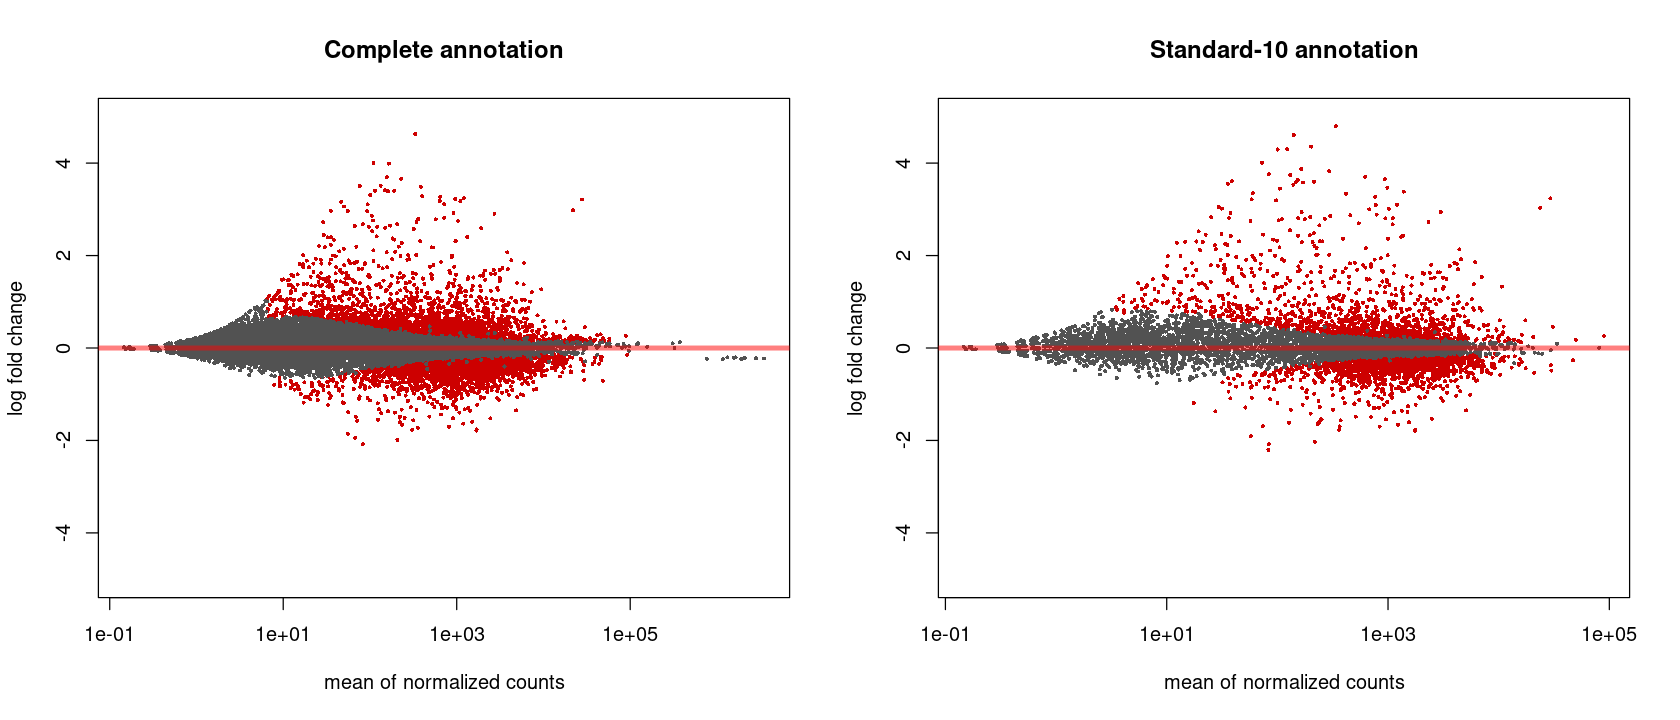

In [7]:
# Display MA plots with shrunken fold changes.

par(mfrow=c(1,2))
options(repr.plot.width = 14, repr.plot.height = 6)
DESeq2::plotMA(results_all, ylim = c(-5,5), main = "Complete annotation")
DESeq2::plotMA(results_std, ylim = c(-5,5), main = "Standard-10 annotation")

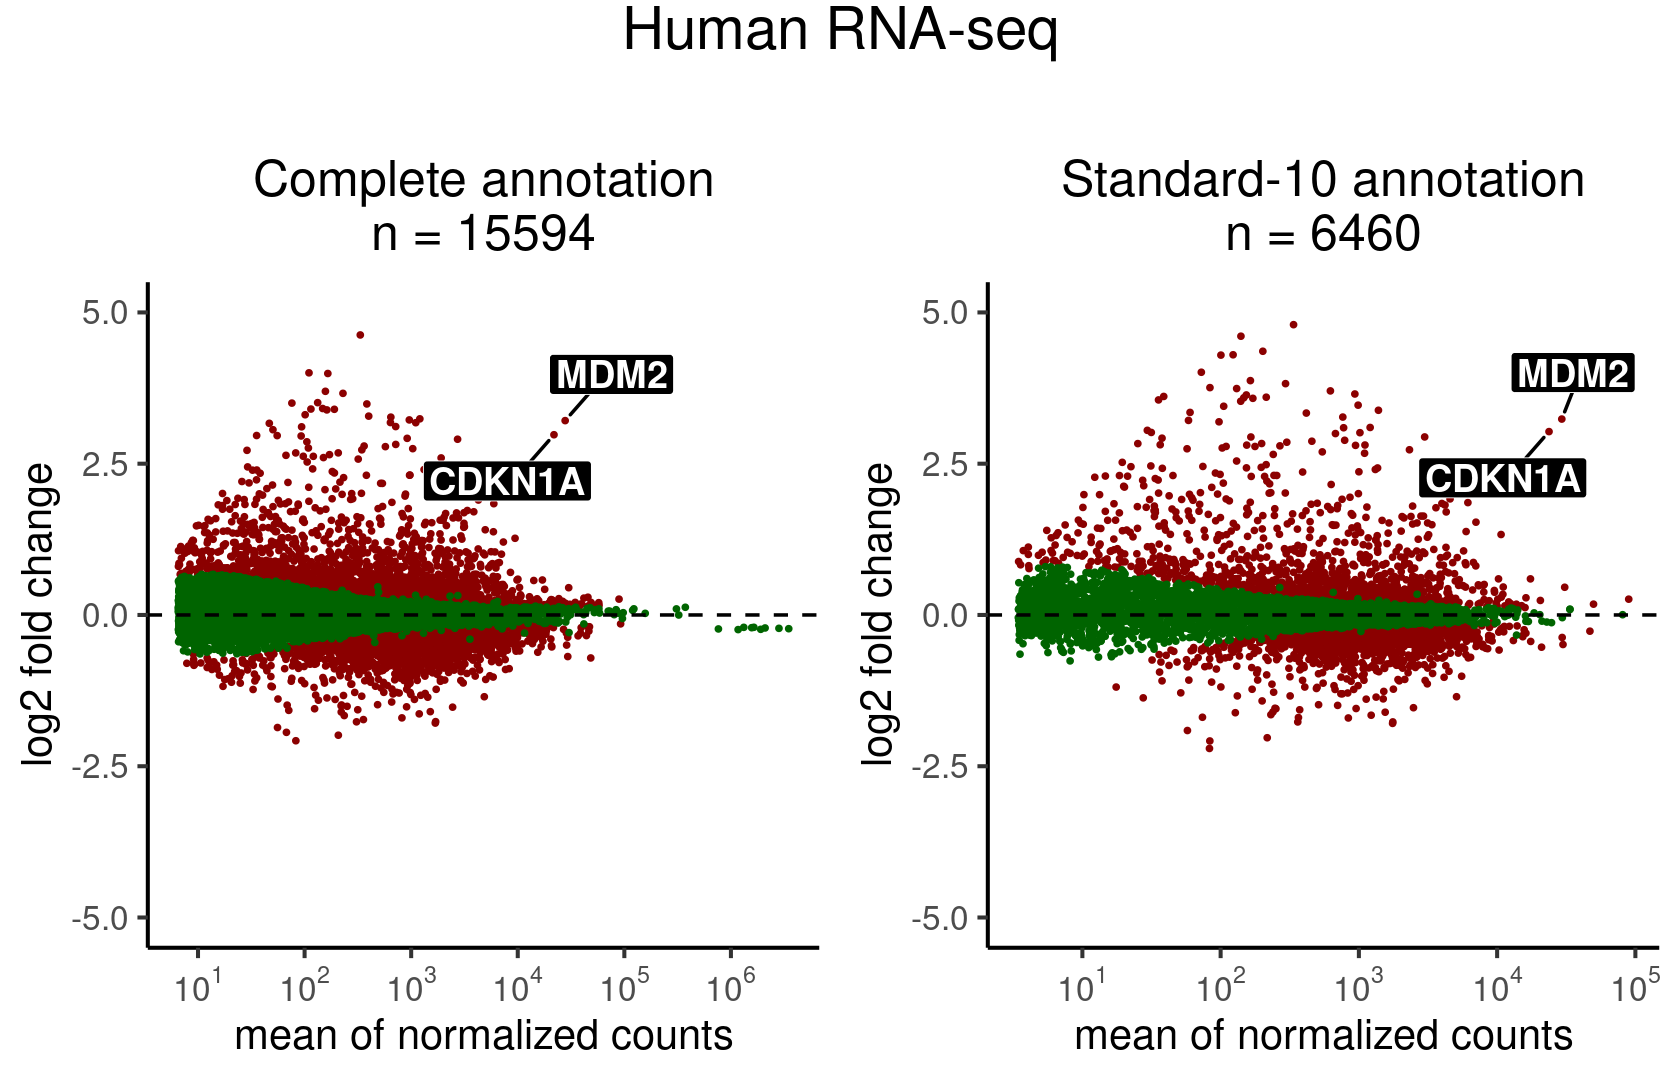

In [8]:
#############################################
            # Complete annotation
#############################################

# Creates dataframe with DESeq2 results for easy plotting.
tempColNames <- c("name","baseMean","log2FoldChange","padj","significant","toLabel")
results_all_df <- data.frame(matrix(ncol = length(tempColNames), nrow = dim(results_all)[1]))
colnames(results_all_df) <- tempColNames
rownames(results_all_df) <- rownames(results_all)
results_all_df$name <- rownames(results_all)
results_all_df$baseMean <- results_all$baseMean
results_all_df$log2FoldChange <- results_all$log2FoldChange
results_all_df$padj <- results_all$padj

# Removes entries that do not have a fold-change or a p-value.
results_all_df <- results_all_df[complete.cases(results_all_df$log2FoldChange),]
results_all_df <- results_all_df[complete.cases(results_all_df$padj),]

# Labels entries as significant if their adjusted p-value is less than the alpha value.
results_all_df$significant <- (results_all_df$padj < alphaValue)

# Marks selected genes for labelling in plot.
geneNames <- c("CDKN1A","MDM2")
#geneNames <- c("ENSGGOG00000014701","ENSGGOG00000012907")
#geneNames <- c("ENSGGOG00000014701.3","ENSGGOG00000012907.3")
#geneNames <- c("ENSNLEG00000017541.3","ENSNLEG00000003757.2")
#geneNames <- c("ENSNLEG00000017541","ENSNLEG00000003757")
#geneNames <- c("ENSSBOG00000019456.1","ENSSBOG00000014544.1")
#geneNames <- c("ENSSBOG00000019456","ENSSBOG00000014544")
results_all_df$toLabel <- results_all_df$name %in% geneNames

# Makes an MA plot.
MA_all <- ggplot(results_all_df, aes(x = baseMean, y = log2FoldChange, label = name)) +
  geom_point(shape = 21, size = 1.5, alpha = 1,
             fill = dplyr::case_when(results_all_df$significant == TRUE ~ "darkred", 
                                     results_all_df$significant == FALSE ~ "darkgreen"),
             color = dplyr::case_when(results_all_df$significant == TRUE ~ "darkred", 
                                     results_all_df$significant == FALSE ~ "darkgreen")) +
  ylim(-5, 5) +
  theme_classic(base_size = 25) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 1) +
  labs(title = paste0("Complete annotation\nn = ", dim(results_all_df)[1]),
       x = "mean of normalized counts",
       y = "log2 fold change") +
  geom_label_repel(data = results_all_df[results_all_df$toLabel == TRUE,],
                   aes(color = "black"),
                   size = 8,
                   box.padding = 1.0,
                   point.padding = 0.5,
                   segment.size = 1,
                   color = "white", 
                   fontface = "bold",
                   fill = "black",
                   force = 20,
                   segment.color = "black") +
  scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
                         labels = trans_format("log10", math_format(10^.x))) +
  theme(legend.position = "none") +
  theme(plot.title = element_text(hjust = 0.5))

#############################################
          # Standard-10 annotation
#############################################
                
# Creates dataframe with DESeq2 results for easy plotting.
tempColNames <- c("name","baseMean","log2FoldChange","padj","significant","toLabel")
results_std_df <- data.frame(matrix(ncol = length(tempColNames), nrow = dim(results_std)[1]))
colnames(results_std_df) <- tempColNames
rownames(results_std_df) <- rownames(results_std)
results_std_df$name <- rownames(results_std)
results_std_df$baseMean <- results_std$baseMean
results_std_df$log2FoldChange <- results_std$log2FoldChange
results_std_df$padj <- results_std$padj

# Removes entries that do not have a fold-change or a p-value.
results_std_df <- results_std_df[complete.cases(results_std_df$log2FoldChange),]
results_std_df <- results_std_df[complete.cases(results_std_df$padj),]

# Labels entries as significant if their adjusted p-value is less than the alpha value.
results_std_df$significant <- (results_std_df$padj < alphaValue)

# Marks selected genes for labelling in plot.
geneNames <- c("CDKN1A","MDM2")
results_std_df$toLabel <- results_std_df$name %in% geneNames

# Makes an MA plot.
MA_std <- ggplot(results_std_df, aes(x = baseMean, y = log2FoldChange, label = name)) +
  geom_point(shape = 21, size = 1.5, alpha = 1,
             fill = dplyr::case_when(results_std_df$significant == TRUE ~ "darkred", 
                                     results_std_df$significant == FALSE ~ "darkgreen"),
             color = dplyr::case_when(results_std_df$significant == TRUE ~ "darkred", 
                                     results_std_df$significant == FALSE ~ "darkgreen")) +
  ylim(-5, 5) +
  theme_classic(base_size = 25) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 1) +
  labs(title = paste0("Standard-10 annotation\nn = ", dim(results_std_df)[1]),
       x = "mean of normalized counts",
       y = "log2 fold change") +
  geom_label_repel(data = results_std_df[results_std_df$toLabel == TRUE,],
                   aes(color = "black"),
                   size = 8,
                   box.padding = 1.0,
                   point.padding = 0.5,
                   segment.size = 1,
                   color = "white", 
                   fontface = "bold",
                   fill = "black",
                   force = 20,
                   segment.color = "black") +
  scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
                         labels = trans_format("log10", math_format(10^.x))) +
  theme(legend.position = "none") +
  theme(plot.title = element_text(hjust = 0.5))
                
# Plotting
options(repr.plot.width = 14, repr.plot.height = 9)
grid.arrange(MA_all, MA_std, ncol = 2, top = textGrob(paste0(species, " ", libraryType,"-seq\n"), gp = gpar(fontsize = 35)))        

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Removed 1 rows containing missing values (geom_vline).”
Warning message:
“Removed 1 rows containing missing values (geom_vline).”


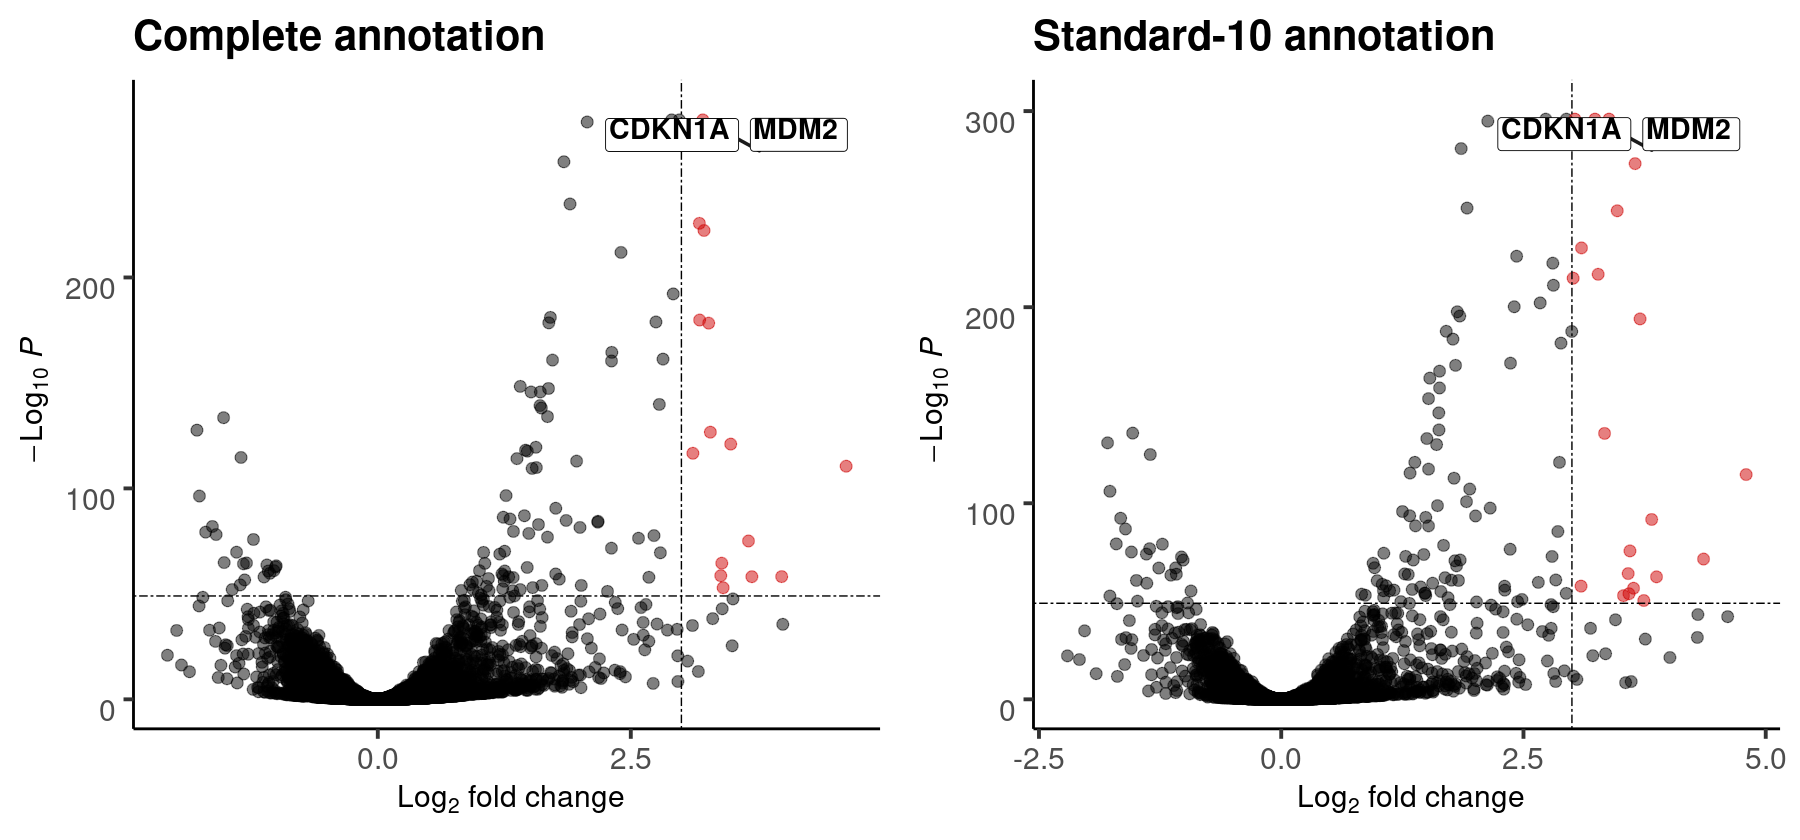

In [9]:
# Makes a volcano plot with the DESeq2 results.

volcano_all <- EnhancedVolcano(results_all_df,
                lab = rownames(results_all_df),
                x = "log2FoldChange",
                y = "padj",
                title = "Complete annotation",
                titleLabSize = 25,
                subtitle = NULL,
                caption = NULL,
                pCutoff = 10e-50,
                FCcutoff = 3,
                cutoffLineType = "twodash",
                pointSize = 3.0,
                labSize = 6.0,
                selectLab = c("MDM2", "CDKN1A"),
                #selectLab = c("ENSNLEG00000017541.3","ENSNLEG00000003757.2"),
                #selectLab = c("ENSSBOG00000019456.1","ENSSBOG00000014544.1"),
                boxedLabels = TRUE,
                labFace = "bold",
                col=c("black", "black", "black", "red3"),
                legendPosition = 'none',
                colAlpha = 0.5,
                gridlines.major = FALSE,
                gridlines.minor = FALSE,
                drawConnectors = TRUE,
                widthConnectors = 1,
                typeConnectors = "open",
                endsConnectors = "last")

volcano_std <- EnhancedVolcano(results_std_df,
                lab = rownames(results_std_df),
                x = "log2FoldChange",
                y = "padj",
                title = "Standard-10 annotation",
                titleLabSize = 25,
                subtitle = NULL,
                caption = NULL,
                pCutoff = 10e-50,
                FCcutoff = 3,
                cutoffLineType = "twodash",
                pointSize = 3.0,
                labSize = 6.0,
                selectLab = c("MDM2", "CDKN1A"),
                boxedLabels = TRUE,
                labFace = "bold",
                col=c("black", "black", "black", "red3"),
                legendPosition = 'none',
                colAlpha = 0.5,
                gridlines.major = FALSE,
                gridlines.minor = FALSE,
                drawConnectors = TRUE,
                widthConnectors = 1,
                typeConnectors = "open",
                endsConnectors = "last")

# Plotting
options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(volcano_all, volcano_std, ncol = 2)

### Downloading gene sets

C2: curated gene sets<br>
c2.all.v7.5.1.symbols.gmt

CGP: chemical and genetic perturbations<br>
c2.cgp.v7.5.1.symbols.gmt

CP: Canonical pathways<br>
c2.cp.v7.5.1.symbols.gmt

C3: regulatory target gene sets<br>
TFT: transcription factor targets<br>
c3.tft.v7.5.1.symbols.gmt

C5: ontology gene sets<br>
BP: subset of GO<br>
c5.go.bp.v7.5.1.symbols.gmt

http://www.gsea-msigdb.org/gsea/msigdb

I removed the http address that is found within every line in the GMT file as follows:
```
sed -i 's/.*http:\/\/www.gsea-msigdb.org\/gsea\/msigdb\/cards\/\(.*\)/\1/g' c2.all.v7.5.1.symbols.gmt
sed -i 's/.*http:\/\/www.gsea-msigdb.org\/gsea\/msigdb\/cards\/\(.*\)/\1/g' c2.cgp.v7.5.1.symbols.gmt
sed -i 's/.*http:\/\/www.gsea-msigdb.org\/gsea\/msigdb\/cards\/\(.*\)/\1/g' c2.cp.v7.5.1.symbols.gmt
sed -i 's/.*http:\/\/www.gsea-msigdb.org\/gsea\/msigdb\/cards\/\(.*\)/\1/g' c3.tft.v7.5.1.symbols.gmt
sed -i 's/.*http:\/\/www.gsea-msigdb.org\/gsea\/msigdb\/cards\/\(.*\)/\1/g' c5.go.bp.v7.5.1.symbols.gmt
```

In [10]:
# Transforming the GMT file onto an R list for FGSEA.

# Read in the data
pathways_GMT <- scan("/Shares/txpnevol/daniel/panSpeciesGeneAnnotation/geneSets/c3.tft_panP53.v7.5.1.symbols.gmt", 
               what = "", sep = "\n")

# Separate elements by one or more whitepace
pathways_list <- strsplit(pathways_GMT, "[[:space:]]+")

# Extract the first vector element and set it as the list element name
names(pathways_list) <- sapply(pathways_list, function(pathways_GMT) pathways_GMT[[1]])
                               
# Remove the first vector element from each list element
pathways_list <- lapply(pathways_list, function(pathways_GMT) pathways_GMT[-1])

## GSEA with Complete Annotation

Warning message in fgsea(pathways = pathways_list, stats = rankedGenes_all_gsea, :
“There are ties in the preranked stats (23.83% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = pathways_list, stats = rankedGenes_all_gsea, :
“There were 9 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


[1] "P53_02"


pathway,pval,padj,ES,NES
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
P53_02,0.02413431,0.5466552,0.3698311,1.306627


[1] "p53_panPrimate_RNAseq_LCL_Nutlin"


pathway,pval,padj,ES,NES
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
p53_panPrimate_RNAseq_LCL_Nutlin,0.001001001,0.3340351,0.6562376,2.386875


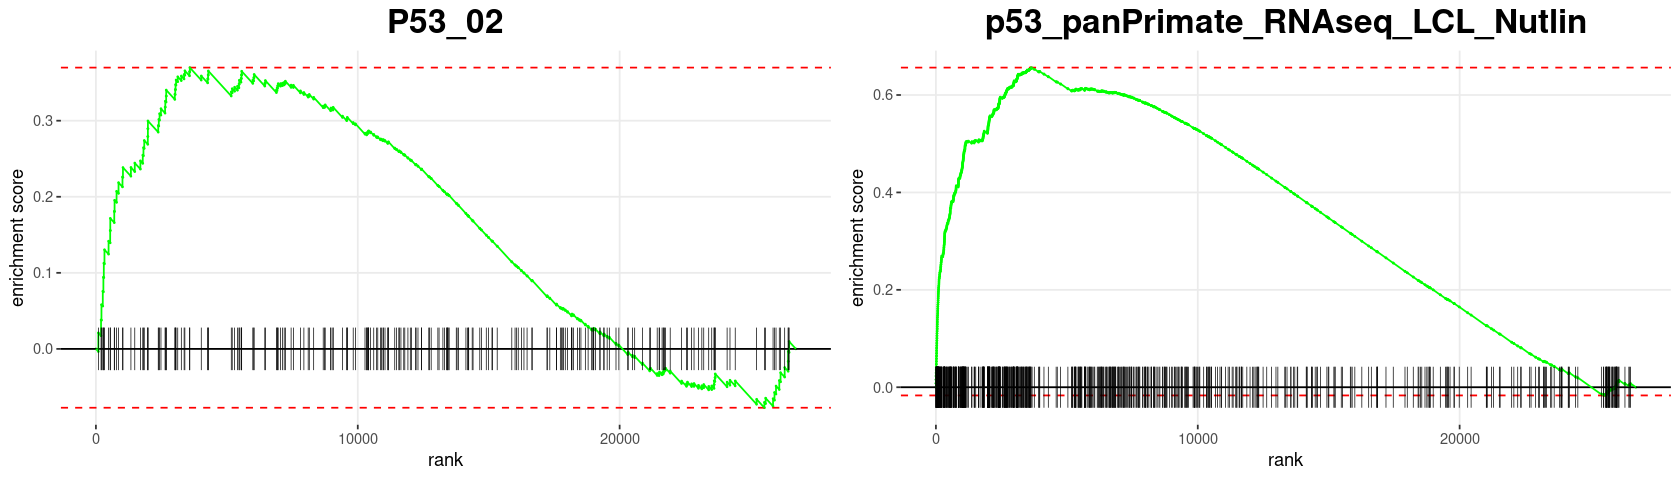

In [11]:
# Run GSEA using the ranked gene list from DESeq2 by fold-change, and the GSEA gene set list.
fgseaRes <- fgsea(pathways = pathways_list, 
                  stats = rankedGenes_all_gsea,
                  minSize = 15,
                  maxSize = 1000,
                  nperm = 1000)

fgseaRes$NES <- as.numeric(fgseaRes$NES)
fgseaRes <- fgseaRes[with(fgseaRes, order(fgseaRes$NES, decreasing = TRUE)), ]

# Plot the enrichment curve for a single pathway.

options(repr.plot.width = 14, repr.plot.height = 4)

P53Pathway = "P53_02"
print(P53Pathway)
fgseaRes[fgseaRes$pathway == P53Pathway, c("pathway","pval","padj","ES","NES")]
P53GSEAplot <- plotEnrichment(pathways_list[[P53Pathway]], rankedGenes_all_gsea) + 
                      labs(title = P53Pathway) + 
                      theme(plot.title = element_text(color = "black", size = 20, face = "bold", hjust = 0.5))

panP53Pathway = "p53_panPrimate_RNAseq_LCL_Nutlin"
print(panP53Pathway)
fgseaRes[fgseaRes$pathway == panP53Pathway, c("pathway","pval","padj","ES","NES")]
panP53GSEAplot <- plotEnrichment(pathways_list[[panP53Pathway]], rankedGenes_all_gsea) + 
                      labs(title = panP53Pathway) + 
                      theme(plot.title = element_text(color = "black", size = 20, face = "bold", hjust = 0.5))

grid.arrange(P53GSEAplot, panP53GSEAplot, ncol = 2)

## GSEA with Standard-10 Annotation

Warning message in fgsea(pathways = pathways_list, stats = rankedGenes_std_gsea, :
“There are ties in the preranked stats (5.8% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = pathways_list, stats = rankedGenes_std_gsea, :
“There were 30 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


[1] "P53_02"


pathway,pval,padj,ES,NES
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
P53_02,0.01321138,0.5945417,0.4868139,1.398975


[1] "p53_panPrimate_RNAseq_LCL_Nutlin"


pathway,pval,padj,ES,NES
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
p53_panPrimate_RNAseq_LCL_Nutlin,0.000999001,0.442193,0.6891195,2.070401


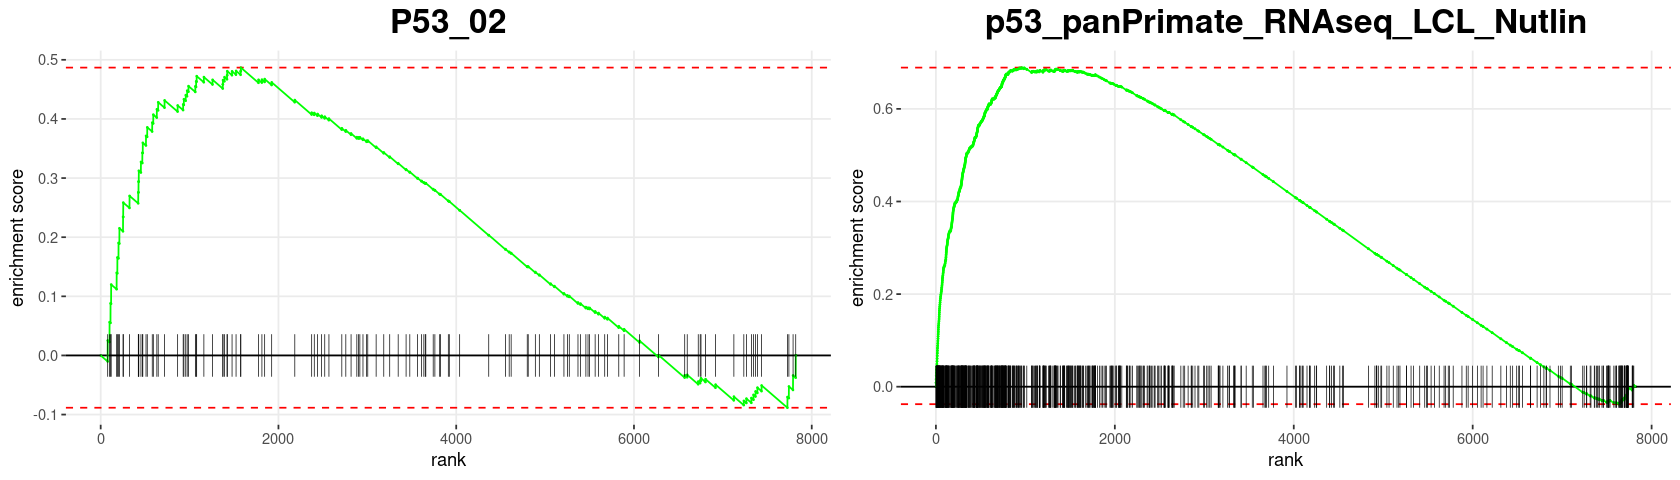

In [12]:
# Run GSEA using the ranked gene list from DESeq2 by fold-change, and the GSEA gene set list.
fgseaRes <- fgsea(pathways = pathways_list, 
                  stats = rankedGenes_std_gsea,
                  minSize = 15,
                  maxSize = 1000,
                  nperm = 1000)

fgseaRes$NES <- as.numeric(fgseaRes$NES)
fgseaRes <- fgseaRes[with(fgseaRes, order(fgseaRes$NES, decreasing = TRUE)), ]

# Plot the enrichment curve for a single pathway.

options(repr.plot.width = 14, repr.plot.height = 4)

P53Pathway = "P53_02"
print(P53Pathway)
fgseaRes[fgseaRes$pathway == P53Pathway, c("pathway","pval","padj","ES","NES")]
P53GSEAplot <- plotEnrichment(pathways_list[[P53Pathway]], rankedGenes_std_gsea) + 
                      labs(title = P53Pathway) + 
                      theme(plot.title = element_text(color = "black", size = 20, face = "bold", hjust = 0.5))

panP53Pathway = "p53_panPrimate_RNAseq_LCL_Nutlin"
print(panP53Pathway)
fgseaRes[fgseaRes$pathway == panP53Pathway, c("pathway","pval","padj","ES","NES")]
panP53GSEAplot <- plotEnrichment(pathways_list[[panP53Pathway]], rankedGenes_std_gsea) + 
                      labs(title = panP53Pathway) + 
                      theme(plot.title = element_text(color = "black", size = 20, face = "bold", hjust = 0.5))

grid.arrange(P53GSEAplot, panP53GSEAplot, ncol = 2)

 [1] "p53_panPrimate_RNAseq_LCL_Nutlin" "GATAAGR_GATA_C"                  
 [3] "TP73_TARGET_GENES"                "HNF4_01"                         
 [5] "GATA_Q6"                          "YAATNRNNNYNATT_UNKNOWN"          
 [7] "TGTTTGY_HNF3_Q6"                  "TATAAA_TATA_01"                  
 [9] "HAND1E47_01"                      "HSF1_01"                         
[11] "E2F_Q6"                           "MEF2_01"                         
[13] "GKCGCNNNNNNNTGAYG_UNKNOWN"        "TMTCGCGANR_UNKNOWN"              
[15] "EPC1_TARGET_GENES"                "HEN1_02"                         
[17] "FOXR2_TARGET_GENES"               "YTCCCRNNAGGY_UNKNOWN"            
[19] "SGCGSSAAA_E2F1DP2_01"             "GGAANCGGAANY_UNKNOWN"            


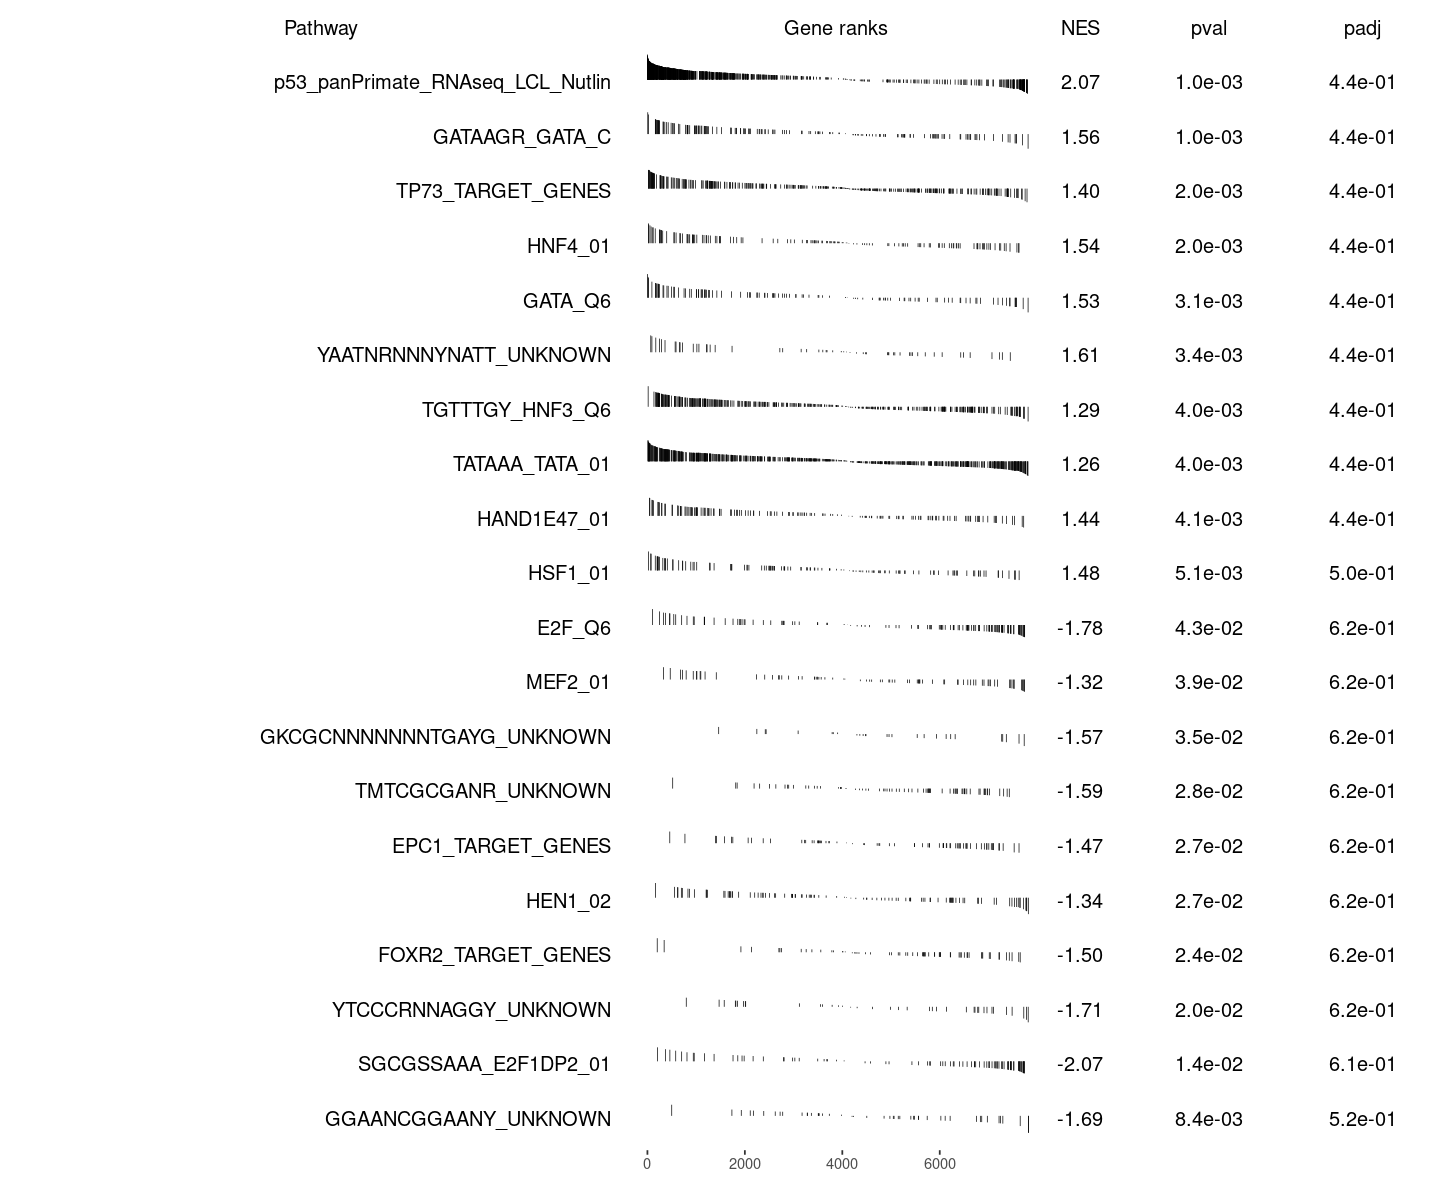

In [13]:
# Plot the enrichment curves for the 10 pathways with the highest ES score,
# and the 10 pathways with the lowest ES score.

topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n = 10), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n = 10), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))

print(topPathways)

options(repr.plot.width = 12, repr.plot.height = 10)
plotGseaTable(pathways = pathways_list[topPathways], 
              stats = rankedGenes_std_gsea, 
              fgseaRes = fgseaRes, 
              gseaParam = 0.5)

## Other websites

https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/05_Annotation_and_Visualisation.nb.html

https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

https://github.com/ctlab/fgsea

http://www.gsea-msigdb.org/gsea/msigdb/collections.jsp#C5

https://learn.gencore.bio.nyu.edu/rna-seq-analysis/gene-set-enrichment-analysis/